### Analysis: Diabetic vs. Prediabetic group post-intervention

In [1]:
#load libraries
#tutorial: https://cran.r-project.org/web/packages/mashr/vignettes/eQTL_outline.html
suppressPackageStartupMessages(library(mashr))
suppressPackageStartupMessages(library(ashr))
suppressPackageStartupMessages(library(AnnotationHub))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(forestplot))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(stringr))
set.seed(1993)
path_to_mash_output <- '/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/fastqtl_to_mash_output/'
#load output in R
mash_output <- readRDS(paste0(file.path(path_to_mash_output),'SumStats.mash.rds'))

Warning message:
“package ‘stringr’ was built under R version 4.3.2”


In [2]:
names(mash_output)

[1] "random.z"      "random.test.z" "strong.z"      "random.b"     
[5] "random.test.b" "strong.b"      "random.s"      "random.test.s"
[9] "strong.s"

#### *.z, *.b and *.s stands for z-scores, beta and standard error of the beta.

#### strong is data of the "strongest" gene-SNP pair; random is a random subset of gene-SNP pairs. They are used to find pattern of sharing in strong signals and learning mixture weights. Additionally random.test.* is a seperate random data-set that can be used to assess fit / overfit of the MASH mixture model.

In [3]:
#set mash data according to the vignette
data.temp = mash_set_data(mash_output$random.b,mash_output$random.s)

#We estimate the correlation structure in the null tests from the random data (not the strong data because they will not necessarily contain any null tests
Vhat = estimate_null_correlation_simple(data.temp)
rm(data.temp)

In [4]:
#create strong and random subset of gene-SNP pairs
data.random = mash_set_data(mash_output$random.b,mash_output$random.s,V=Vhat)
data.strong = mash_set_data(mash_output$strong.b,mash_output$strong.s, V=Vhat)

In [5]:
#Now we use the strong tests to set up data-driven covariances.
U.pca = cov_pca(data.strong,2)
U.ed = cov_ed(data.strong, U.pca)

In [6]:
#fit mash to the random tests using both data-driven and canonical covariances. (Remember the Crucial Rule! We have to fit using a random set of tests, and not a dataset that is enriched for strong tests.) The outputlevel=1 option means that it will not compute posterior summaries for these tests (which saves time).
U.c = cov_canonical(data.random)
m = mash(data.random, Ulist = c(U.ed,U.c), outputlevel = 1)

 - Computing 11070 x 191 likelihood matrix.
 - Likelihood calculations took 1.46 seconds.
 - Fitting model with 191 mixture components.
 - Model fitting took 2.10 seconds.


In [7]:
#compute posterior summaries
m2 = mash(data.strong, g=get_fitted_g(m), fixg=TRUE)

 - Computing 2460 x 191 likelihood matrix.
 - Likelihood calculations took 0.14 seconds.
 - Computing posterior matrices.
 - Computation allocated took 0.03 seconds.


In [8]:
#get metrics of interest to determine specificity/response-eQTL
#get local false sign rate
results_lsfr <- get_lfsr(m2)

#get posterior mean
results_effect <- get_pm(m2)

#get posterior standard deviation
results_sd <- get_psd(m2)

# bad_ids <- c("OID20816", "OID20775", "OID21485")

# results_lsfr <- results_lsfr[!grepl(paste(bad_ids, collapse = "|"), rownames(results_lsfr)), ]
# results_effect <- results_effect[!grepl(paste(bad_ids, collapse = "|"), rownames(results_effect)), ]
# results_sd <- results_sd[!grepl(paste(bad_ids, collapse = "|"), rownames(results_sd)), ]


In [9]:
#Find effects that are significant in at least one condition
#https://stephenslab.github.io/mashr/reference/get_significant_results.html
sig_res_diabetic <- get_significant_results(m2, conditions = '4_diabetic')
sig_res_prediabetic <- get_significant_results(m2, conditions = '5_prediabetes')

#check how many sigificant
cat("Total significant hits:", length(get_significant_results(m2)))
cat("\n")
cat("Total significant hits in diabetic group:", length(sig_res_diabetic))
cat("\n")
cat("Total significant hits in prediabetic group:", length(sig_res_prediabetic))
cat("\n")
#check how many different
cat("No. of different hits in grp 1:", length(setdiff(sig_res_diabetic, sig_res_prediabetic)))
cat("\n")
cat("No. of different hits in grp 2:", length(setdiff(sig_res_prediabetic, sig_res_diabetic)))
cat("\n")
#check how many common
cat("No. of hits common between the two groups:", length(intersect(sig_res_diabetic, sig_res_prediabetic)))

Total significant hits: 789
Total significant hits in diabetic group: 703
Total significant hits in prediabetic group: 789
No. of different hits in grp 1: 0
No. of different hits in grp 2: 86
No. of hits common between the two groups: 703

### Writing the files

In [10]:
# ----------------------------
# Helper function to prepare and write results
prepare_results <- function(effect_mat, lsfr_mat, signals, out_file, prot_ids, sample, drop_diabetes_cols = FALSE) {
  # Extract relevant rows
  df_effect <- as.data.frame(effect_mat[signals, ])
  df_lsfr   <- as.data.frame(lsfr_mat[signals, ])
  
  # Combine
  comb_df <- cbind(df_effect, df_lsfr)
  
  # Rename the first 4 columns consistently
  colnames(comb_df)[1:4] <- c(
    "T2_diabetic_posterior_beta",
    "T2_prediabetes_posterior_beta",
    "T2_diabetic_lsfr",
    "T2_prediabetes_lsfr"
  )
  
  # Add signal as a column
  comb_df <- tibble::rownames_to_column(comb_df, var = "signal")
  
  # Optionally drop diabetes columns (for prediabetes-only results)
  if (drop_diabetes_cols) {
    comb_df <- comb_df %>% select(-T2_diabetic_posterior_beta, -T2_diabetic_lsfr)
  }
  
  # Force LSFR columns into scientific notation
  lsfr_cols <- grep("lsfr$", names(comb_df), value = TRUE)
  comb_df[, lsfr_cols] <- lapply(comb_df[, lsfr_cols, drop = FALSE], 
                                 function(x) formatC(x, format = "e", digits = 4))
  
  # ----------------------------
  # Split signal into OlinkID and SNP, add chr, and join prot_ids
  comb_df <- comb_df %>%
    separate(signal, into = c("OlinkID", "SNP"), sep = "_", remove = FALSE) %>%
    mutate(SNP = ifelse(!grepl("^chr", SNP), paste0("chr", SNP), SNP)) %>%
    left_join(prot_ids %>% select(OlinkID, Assay), by = "OlinkID")
  
  # ----------------------------
  # Match SNP with sample dataframe, keep only A1 and A2, and rename them
  comb_df <- comb_df %>%
    left_join(sample %>% select(SNP, A1, A2), by = "SNP") %>%
    rename(effect_allele = A1, other_allele = A2)
  
  # ----------------------------
  # Final formatting (robust to missing T2D columns)
  comb_df <- comb_df %>%
    # Rename Assay to Protein
    rename(Protein = Assay) %>%
    # Create combined Protein_SNP column
    mutate(Protein_SNP = paste0(Protein, "_", SNP)) %>%
    # Rename beta/lsfr columns if they exist
    rename_with(~ gsub("T2_diabetic_posterior_beta", "T2D_posterior_beta", .x), 
                .cols = intersect(names(.), "T2_diabetic_posterior_beta")) %>%
    rename_with(~ gsub("T2_prediabetes_posterior_beta", "Prediabetes_posterior_beta", .x),
                .cols = intersect(names(.), "T2_prediabetes_posterior_beta")) %>%
    rename_with(~ gsub("T2_diabetic_lsfr", "T2D_lfsr", .x), 
                .cols = intersect(names(.), "T2_diabetic_lsfr")) %>%
    rename_with(~ gsub("T2_prediabetes_lsfr", "Prediabetes_lfsr", .x), 
                .cols = intersect(names(.), "T2_prediabetes_lsfr")) %>%
    # Drop unused columns
    select(-signal, -OlinkID) %>%
    # Reorder columns (keep only those that exist)
    select(
      Protein,
      Protein_SNP,
      effect_allele,
      other_allele,
      intersect(c("T2D_posterior_beta", "Prediabetes_posterior_beta", "T2D_lfsr", "Prediabetes_lfsr"), names(.))
    )
  
  # ----------------------------
  # Write to file
  fwrite(comb_df, out_file, sep = "\t")
  
  return(comb_df)
}

# ----------------------------
# Read prot_ids and sample once, outside the function
prot_ids <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv")
#getting the ref and alternate allele info
sample <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/PLIS_prediabetic_5/OID21432.20240923/gcta/gcta.mlma.gz", sep = "\t")
# ----------------------------
# 1. Shared signals (diabetes ∩ prediabetes)
shared_signals <- intersect(sig_res_diabetic, sig_res_prediabetic)

sig_diabetes_comb <- prepare_results(
  effect_mat = results_effect,
  lsfr_mat   = results_lsfr,
  signals    = shared_signals,
  out_file   = "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/shared_sig_signals_prediabetes-diabetes_group.txt",
  prot_ids   = prot_ids,
  sample     = sample
)

# ----------------------------
# 2. Prediabetes-only signals
sig_prediabetes_comb <- prepare_results(
  effect_mat = results_effect,
  lsfr_mat   = results_lsfr,
  signals    = names(sig_res_prediabetic),
  out_file   = "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/sig_signals_prediabetes_group.txt",
  prot_ids   = prot_ids,
  sample     = sample,
  drop_diabetes_cols = TRUE
)

# ----------------------------
# 1. Remove unwanted OlinkIDs from both datasets
excluded_olinks <- c("OID20816", "OID20775", "OID21485")

sig_diabetes_comb <- sig_diabetes_comb %>%
  filter(!Protein %in% prot_ids$Assay[prot_ids$OlinkID %in% excluded_olinks])

sig_prediabetes_comb <- sig_prediabetes_comb %>%
  filter(!Protein %in% prot_ids$Assay[prot_ids$OlinkID %in% excluded_olinks])

# Write the filtered outputs back
fwrite(sig_diabetes_comb, 
           "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/shared_sig_signals_filtered.csv", 
       sep = ",")

fwrite(sig_prediabetes_comb, 
       "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/sig_prediabetes_filtered.csv", 
       sep = ",")

# ----------------------------
# 2. Identify unique prediabetes signals (Proteins not in diabetes)
unique_prediabetes <- sig_prediabetes_comb %>%
  filter(!Protein %in% sig_diabetes_comb$Protein)

# Write unique prediabetes signals to a new file
fwrite(unique_prediabetes, 
       "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/unique_prediabetes_signals.csv", 
       sep = ",")


### Forest plot of shared pQTLs with opposite effects between T2D and prediabetes

In [11]:
# Filter SNPs with opposite effect directions
opposite_snps <- sig_diabetes_comb %>%
  filter(sign(T2D_posterior_beta) != sign(Prediabetes_posterior_beta))

In [12]:
results_sd <- as.data.frame(results_sd)
# 1️⃣ Convert rownames of results_sd to "chr:pos" format
results_sd <- results_sd %>%
  tibble::rownames_to_column(var = "SNP_id") %>%   # move rownames to a column
  mutate(
    SNP_id = str_replace(SNP_id, ".*_", ""),      # remove everything before '_', e.g., OID20049_1:11915467 -> 1:11915467
    SNP_id = str_replace(SNP_id, "chr", "")       # remove 'chr' if present
  )

# 2️⃣ Rename SD columns
results_sd <- results_sd %>%
  rename(
    SD_T2D = `4_diabetic`,
    SD_Prediabetes = `5_prediabetes`
  )

# 3️⃣ Prepare Protein_SNP for matching
opposite_snps <- opposite_snps %>%
  mutate(
    SNP_match = str_replace(Protein_SNP, ".*_chr", ""),  # CD33_chr19:51718317 -> 19:51718317
  )

# 4️⃣ Join SDs to opposite_snps
opposite_snps <- opposite_snps %>%
  left_join(results_sd, by = c("SNP_match" = "SNP_id"))

# 5️⃣ Check
head(opposite_snps %>% select(Protein_SNP, SNP_match, SD_T2D, SD_Prediabetes))

,Protein_SNP,SNP_match,SD_T2D,SD_Prediabetes
,<chr>,<chr>,<dbl>,<dbl>
1,CD33_chr19:51718317,19:51718317,0.08113387,0.07142004
2,MEP1B_chr18:29797958,18:29797958,0.08042400,0.07401087
3,VEGFA_chr6:43925607,6:43925607,0.07887464,0.07308696
4,TGOLN2_chr2:85554080,2:85554080,0.07811005,0.07425685
5,VCAN_chr5:82832139,5:82832139,0.07720130,0.07307308
6,IL17RA_chr22:17586583,22:17586583,0.07826682,0.07375553


In [13]:
# Filter for opposite effects
opposite_df <- opposite_snps %>%
  filter(sign(T2D_posterior_beta) != sign(Prediabetes_posterior_beta)) %>%
  # Compute 95% CI for T2D and Prediabetes
  mutate(
    T2D_lower = T2D_posterior_beta - 1.96 * SD_T2D,
    T2D_upper = T2D_posterior_beta + 1.96 * SD_T2D,
    Pred_lower = Prediabetes_posterior_beta - 1.96 * SD_Prediabetes,
    Pred_upper = Prediabetes_posterior_beta + 1.96 * SD_Prediabetes
  ) %>%
  # Make a long-format dataframe for plotting
  tidyr::pivot_longer(
    cols = c(T2D_posterior_beta, Prediabetes_posterior_beta),
    names_to = "Condition",
    values_to = "Beta"
  ) %>%
  mutate(
    lower = ifelse(Condition == "T2D_posterior_beta", T2D_lower, Pred_lower),
    upper = ifelse(Condition == "T2D_posterior_beta", T2D_upper, Pred_upper),
    Condition = recode(Condition,
                       "T2D_posterior_beta" = "T2D",
                       "Prediabetes_posterior_beta" = "Prediabetes")
  )


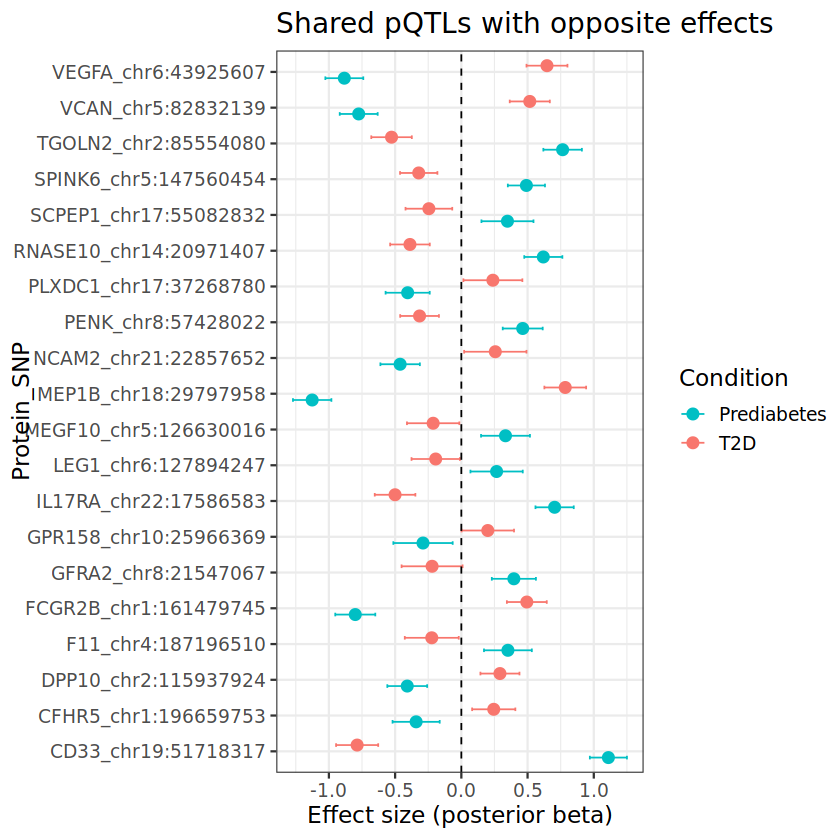

In [14]:
# p <- ggplot(opposite_df, aes(x = Beta, y = Protein_SNP, color = Condition)) +
#   geom_point(position = position_dodge(width = 0.7), size = 3) +
#   geom_errorbarh(aes(xmin = lower, xmax = upper),
#                  position = position_dodge(width = 0.7), height = 0.2) +
#   geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
#   labs(
#     x = "Effect size (posterior beta)",
#     y = "Protein_SNP",
#     title = "Shared pQTLs with opposite effects"
#   ) +
#   theme_bw(base_size = 14)
p <- ggplot(opposite_df, aes(x = Beta, y = Protein_SNP, color = Condition)) +
  geom_point(position = position_dodge(width = 0.7), size = 3) +
  geom_errorbarh(aes(xmin = lower, xmax = upper),
                 position = position_dodge(width = 0.7), height = 0.2) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
  labs(
    x = "Effect size (posterior beta)",
    y = "Protein_SNP",
    title = "Shared pQTLs with opposite effects"
  ) +
  theme_bw(base_size = 14) +
  scale_color_manual(
    values = setNames(
      rev(scales::hue_pal()(length(unique(opposite_df$Condition)))),
      levels(opposite_df$Condition)
    )
  )

print(p)
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_pQTL/T2_comparison/diabetes_vs_prediabetes/mashr_analysis/shared_pQTLs_with_opposite_effects.pdf", plot = p, width = 12, height = 7)